##### Surface map of METAR data
---

In [1]:
from datetime import datetime,timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.calc import wind_components, reduce_point_density
from metpy.units import units
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover, wx_code_map
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
%run /kt11/ktyle/python/metargem.py # Load in a collection of functions that process GEMPAK weather conditions and cloud cover data.

In [2]:
# Use the current time, or set your own for a past time.
# Set current to False if you want to specify a past time.

nowTime = datetime.utcnow()
#current = True
current = False
if (current):
    validTime = datetime.utcnow()
    year = validTime.year
    month = validTime.month
    day = validTime.day
    hour = validTime.hour
else:
    year = 2014
    month = 11
    day = 17
    hour = 12
    
validTime = datetime(year, month, day, hour)
deltaTime = nowTime - validTime
deltaDays = deltaTime.days
timeStr = validTime.strftime("%Y-%m-%d %H UTC")
timeStr2 = validTime.strftime("%Y%m%d%H")
print(timeStr)
print(timeStr2)
print(validTime)
print(deltaTime)
print(deltaDays)

2014-11-17 12 UTC
2014111712
2014-11-17 12:00:00
2717 days, 10:15:20.532022
2717


In [3]:
if (deltaDays <= 7):
    metar_cat_url = 'http://thredds.atmos.albany.edu:8080/thredds/catalog/metar/ncdecodedNAm/catalog.xml?dataset=metar/ncdecodedNAm/Metar_NAm_Station_Data_fc.cdmr'
    #NOTE:  The above catalog uses a limited subset of stations over North America only.
    #For *all* available global stations, use the catalog below.
else:
    metar_cat_url = 'http://thredds.atmos.albany.edu:8080/thredds/catalog/metarArchive/ncdecoded/catalog.xml?dataset=metarArchive/ncdecoded/Archived_Metar_Station_Data_fc.cdmr'

In [4]:
# Create a TDS catalog object from the URL we created above, and examine it.
# The .cdmr extension represents a dataset that works especially well with irregularly-spaced point data sources, such as METAR sites.

catalog = TDSCatalog(metar_cat_url)
catalog

Feature Collection

In [5]:
# This tells us that there is only one dataset type within this catalog, namely a Feature Collection. We now create an object to store this dataset.
metar_dataset = catalog.datasets['Feature Collection']

In [6]:
ncss_url = metar_dataset.access_urls['NetcdfSubset']
print(ncss_url)
# Import ncss client
ncss = NCSS(ncss_url)

http://thredds.atmos.albany.edu:8080/thredds/ncss/metarArchive/ncdecoded/Archived_Metar_Station_Data_fc.cdmr


In [7]:
ncss.variables

{'ALTI',
 'CEIL',
 'CHC1',
 'CHC2',
 'CHC3',
 'COUN',
 'CTYH',
 'CTYL',
 'CTYM',
 'DRCT',
 'DWPC',
 'GUST',
 'MSUN',
 'P01I',
 'P03C',
 'P03D',
 'P03I',
 'P06I',
 'P24I',
 'PMSL',
 'SKNT',
 'SNEW',
 'SNOW',
 'SPRI',
 'STAT',
 'STD2',
 'STNM',
 'T6NC',
 'T6XC',
 'TDNC',
 'TDXC',
 'TMPC',
 'VSBY',
 'WEQS',
 'WNUM',
 '_isMissing'}

In [8]:
# Set the domain to gather data from and for defining the plot region.
latN = 55
latS = 20
lonW = -125
lonE = -60
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2

In [9]:
query = ncss.query()

query.lonlat_box(north=latN-.25, south=latS+0.5, east=lonE-.25, west=lonW+.25)

# We actually specify a time one minute earlier than the specified hour; this is a quirk of how the data is stored on the THREDDS server and ensures we will get data
# corresponding to the hour we specified
query.time(validTime - timedelta(minutes = 1))

# Select the variables to query.  Note that the variable names depend on the source of the METAR data.
# The 'GEMPAK-like' 4-character names are from the UAlbany THREDDS.

query.variables('TMPC', 'DWPC', 'PMSL',
                'SKNT', 'DRCT','ALTI','WNUM','VSBY','CHC1', 'CHC2', 'CHC3','CTYH', 'CTYM', 'CTYL' )
query.accept('csv')

var=DWPC&var=DRCT&var=CHC3&var=VSBY&var=CTYH&var=SKNT&var=ALTI&var=TMPC&var=WNUM&var=CHC1&var=PMSL&var=CTYM&var=CTYL&var=CHC2&time=2014-11-17T11%3A59%3A00&west=-124.75&east=-60.25&south=20.5&north=54.75&accept=csv

In [10]:
data = ncss.get_data(query)
df = pd.DataFrame(data)
df

/knight/anaconda_jan21/envs/aug21/lib/python3.8/site-packages/siphon/ncss.py:432: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arrs = np.genfromtxt(fobj, dtype=None, names=names, delimiter=',',


,time,station,latitude,longitude,DWPC,DRCT,CHC3,VSBY,CTYH,SKNT,ALTI,TMPC,WNUM,CHC1,PMSL,CTYM,CTYL,CHC2
0,b'2014-11-17T12:00:00Z',b'DYS',32.430,-99.849,-8.6,310.0,NaN,10.0,NaN,6.0,30.349998,-5.4,NaN,1.0,1030.70010,NaN,NaN,NaN
1,b'2014-11-17T12:00:00Z',b'NUW',48.349,-122.650,-4.4,120.0,NaN,10.0,NaN,4.0,30.390000,-1.7,NaN,1.0,1029.40000,NaN,NaN,NaN
2,b'2014-11-17T12:00:00Z',b'NYL',32.650,-114.620,-17.2,360.0,NaN,10.0,NaN,12.0,30.189999,12.8,NaN,1802.0,1022.20000,NaN,NaN,2502.0
3,b'2014-11-17T12:00:00Z',b'CAHR',46.349,-63.169,0.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1020.10004,NaN,NaN,NaN
4,b'2014-11-17T12:00:00Z',b'CPBT',49.569,-113.050,-11.0,240.0,NaN,NaN,NaN,9.0,NaN,-8.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585,b'2014-11-17T12:00:00Z',b'NUI',38.139,-76.430,6.1,240.0,NaN,5.0,NaN,4.0,29.859999,8.3,9.0,44.0,1011.20000,NaN,NaN,NaN
1586,b'2014-11-17T12:40:00Z',b'SIF',36.439,-79.849,6.2,0.0,NaN,2.5,NaN,0.0,29.820000,6.3,13.0,23.0,NaN,NaN,NaN,114.0
1587,b'2014-11-17T12:00:00Z',b'OMN',29.299,-81.110,19.0,0.0,NaN,10.0,NaN,0.0,29.990000,19.0,NaN,1.0,NaN,NaN,NaN,NaN
1588,b'2014-11-17T12:40:00Z',b'CLK',35.529,-98.930,-12.0,NaN,NaN,NaN,NaN,NaN,30.369999,-10.0,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
lats = data['latitude']
lons = data['longitude']
tair = (data['TMPC'] * units ('degC')).to('degF')
dewp = (data['DWPC'] * units ('degC')).to('degF')
altm = (data['ALTI'] * units('inHg')).to('mbar')
slp = data['PMSL']

# Convert wind to components
u, v = wind_components(data['SKNT'] * units.knots, data['DRCT'] * units.degree)

# replace missing wx codes or those >= 100 with 0, and convert to MetPy's present weather code
wnum = (np.nan_to_num(data['WNUM'],True).astype(int))
convert_wnum (wnum)



# Need to handle missing (NaN) and convert to proper code
chc1 = (np.nan_to_num(data['CHC1'],True).astype(int))
chc2 = (np.nan_to_num(data['CHC2'],True).astype(int))
chc3 = (np.nan_to_num(data['CHC3'],True).astype(int))
cloud_cover = calc_clouds(chc1, chc2, chc3)

# For some reason station id's come back as bytes instead of strings. This line converts the array of station id's into an array of strings.
stid = np.array([s.decode() for s in data['station']])



In [30]:
# Project points so that we're filtering based on the way the stations are laid out on the map
proj = ccrs.Stereographic(central_longitude=cLon, central_latitude=cLat)
xy = proj.transform_points(ccrs.PlateCarree(), lons, lats)

# Reduce point density so that there's only one point within a circle whose distance is specified in meters.
# This value will need to change depending on how large of an area you are plotting.
density = 300000
mask = reduce_point_density(xy, density)

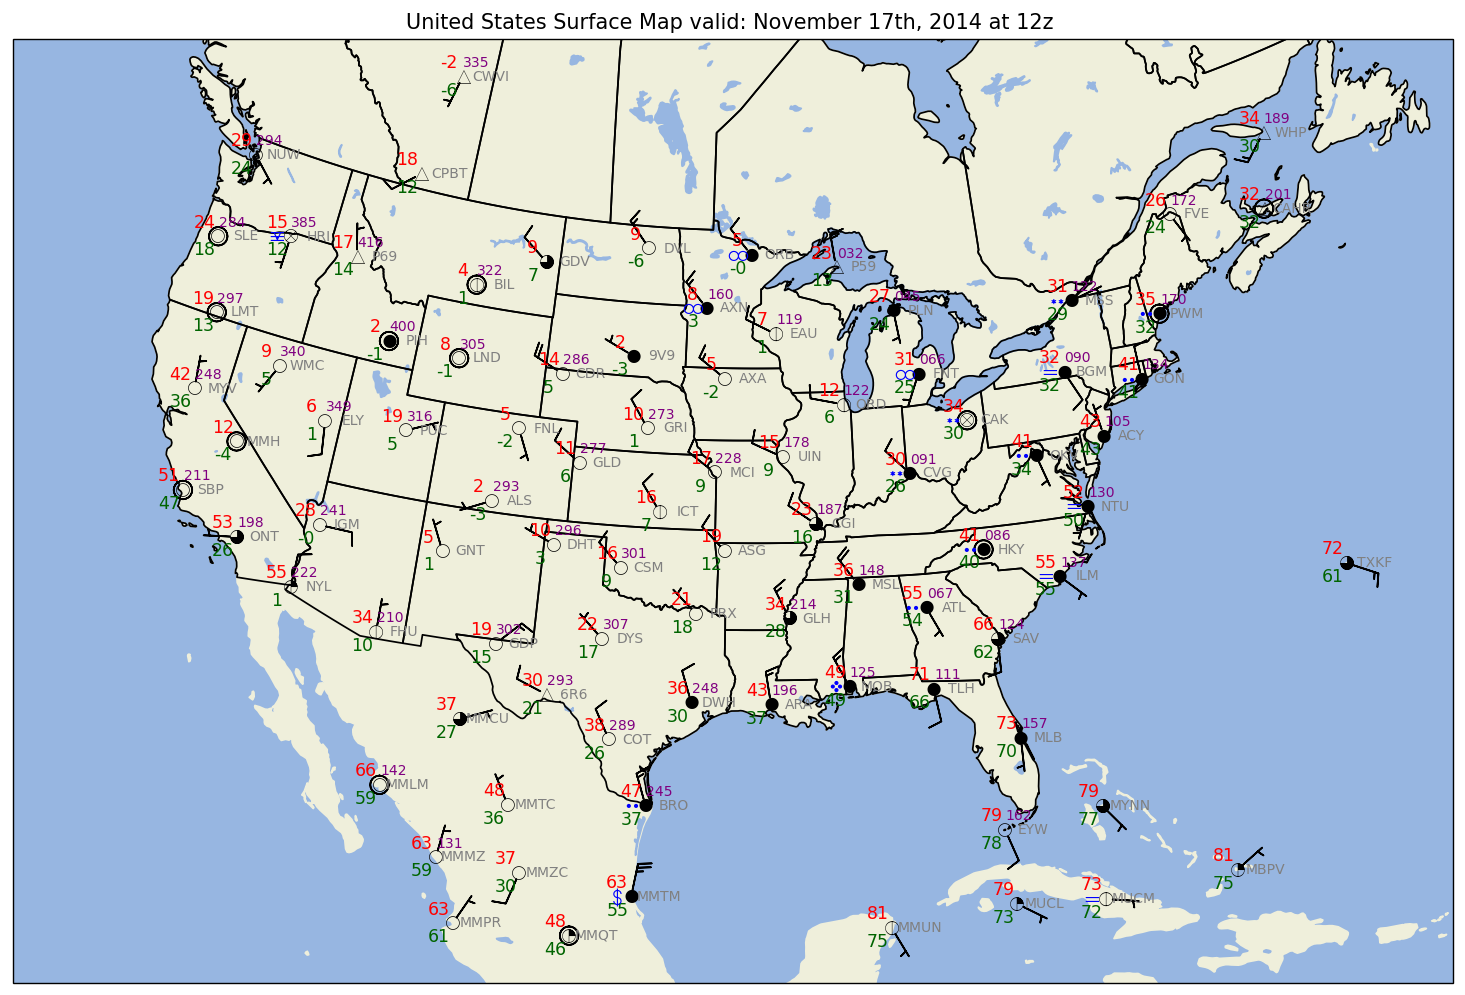

In [31]:
# Set up a plot with map features
# First set dpi ("dots per inch") - higher values will give us a less pixelated final figure.
dpi = 125

fig = plt.figure(figsize=(15,10), dpi=dpi)

proj = ccrs.Stereographic(central_longitude=cLon, central_latitude=cLat)
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.set_facecolor(cfeature.COLORS['water'])

land_mask = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
lake_mask = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['water'])
state_borders = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes',
                                         scale='50m', facecolor='none')

ax.add_feature(land_mask)
ax.add_feature(lake_mask)
ax.add_feature(state_borders, linestyle='solid', edgecolor='black')

# Slightly reduce the extent of the map as compared to the subsetted data region; this helps eliminate data from being plotted beyond the frame of the map
ax.set_extent ((lonW+2,lonE-4,latS-1,latN-2), crs=ccrs.PlateCarree())


#If we wanted to add grid lines to our plot:
#ax.gridlines()

# Create a station plot pointing to an Axes to draw on as well as the location of points
stationplot = StationPlot(ax, lons[mask], lats[mask], transform=ccrs.PlateCarree(),
                          fontsize=8)

stationplot.plot_parameter('NW', tair[mask], color='red', fontsize=10)
stationplot.plot_parameter('SW', dewp[mask], color='darkgreen', fontsize=10)

# Below, we are using a custom formatter to control how the sea-level pressure
# values are plotted. This uses the standard trailing 3-digits of the pressure value
# in tenths of millibars.
stationplot.plot_parameter('NE', slp[mask], color='purple', formatter=lambda v: format(10 * v, '.0f')[-3:])



stationplot.plot_symbol('C', cloud_cover[mask], sky_cover)
stationplot.plot_symbol('W', wnum[mask], current_weather,color='blue',fontsize=12)
stationplot.plot_text((2, 0),stid[mask], color='gray')
#zorder - Higher value zorder will plot the variable on top of lower value zorder. This is necessary for wind barbs to appear. Default is 1.
stationplot.plot_barb(u[mask], v[mask],zorder=2)

plt.title("United States Surface Map valid: November 17th, 2014 at 12z ")
plt.savefig (timeStr2 + '_sfmap.png',dpi=dpi)

In [ ]:
# In order to see the entire figure, type the name of the figure object below.
fig